In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amini-cocoa-contamination-challenge-dataset/CoCoa_Disease_Starter_Notebook.ipynb
/kaggle/input/amini-cocoa-contamination-challenge-dataset/submission.csv
/kaggle/input/amini-cocoa-contamination-challenge-dataset/Train.csv
/kaggle/input/amini-cocoa-contamination-challenge-dataset/Test.csv
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_nx4hoN.txt
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_BJOnhx.txt
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_MW4x3o.txt
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_U0C2nH.txt
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_TFyPYv.txt
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_rHthHf.txt
/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/labels/train/ID_esabf4.txt
/kaggle/input/amini-cocoa-contamination-challe

In [2]:
# pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
# Install ultralytics
!pip -q install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 24.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/amini-cocoa-contamination-challenge-dataset/Train.csv')
unique_classes = df['class'].unique()
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
print(class_mapping)

{'healthy': 0, 'anthracnose': 1, 'cssvd': 2}


In [5]:
df.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
from pathlib import Path

# Set the data directory
DATA_DIR = Path('/kaggle/input/amini-cocoa-contamination-challenge-dataset')

train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'submission.csv')

# Add an image_path column
train['ImagePath'] = [Path('/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/images/train/' + x) for x in train.Image_ID]
test['ImagePath'] = [Path('/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/images/test/' + x) for x in test.Image_ID]

train['ImagePath'][0]

PosixPath('/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/images/train/ID_nBgcAR.jpg')

In [8]:
import cv2
import matplotlib.pyplot as plt

img = '/kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/images/train/ID_nBgcAR.jpg'
img = cv2.imread(img)

In [9]:
def imshow(image = None,title = "Image", size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis(False)
    plt.show()

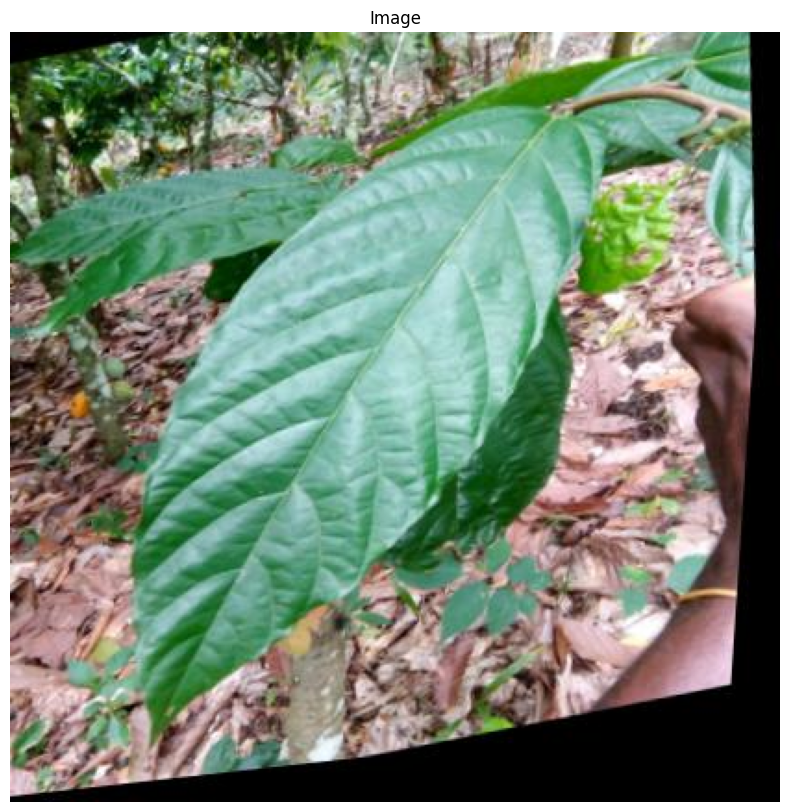

In [10]:
imshow(img)

In [11]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

# Load train and test files
# train = pd.read_csv(DATA_DIR / 'Train.csv')
# test = pd.read_csv(DATA_DIR / 'Test.csv')
# ss = pd.read_csv(DATA_DIR / 'submission.csv')

# Add an image_path column
# train['ImagePath'] = [Path('/kaggle/input/amini-cocoa-contamination-challenge-dataset/images/' + x) for x in train.Image_ID]
# test['ImagePath'] = [Path('/kaggle/input/amini-cocoa-contamination-challenge-dataset/images/' + x) for x in test.Image_ID]

# Map string classes to integers (label encoding targets)
train['class_id'] = train['class'].map(
    {'healthy': 0, 'anthracnose': 1, 'cssvd': 2})

# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset=['Image_ID'], ignore_index=True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size=0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check the shapes of training and validation data
print(X_train.shape, X_val.shape)

# Define directories for images and labels
TRAIN_IMAGES_DIR = Path('/kaggle/working/train/images')
VAL_IMAGES_DIR = Path('/kaggle/working/val/images')
TEST_IMAGES_DIR = Path('/kaggle/working/test/images')
TRAIN_LABELS_DIR = Path('/kaggle/working/train/labels')
VAL_LABELS_DIR = Path('/kaggle/working/val/labels')
TEST_LABELS_DIR = Path('/kaggle/working/test/labels')

# Create necessary directories
for DIR in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_LABELS_DIR, TEST_LABELS_DIR]:
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok=True)

# Copy train, val, and test images to their respective dirs
for img in tqdm(X_train.ImagePath.unique()):
    shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.ImagePath.unique()):
    shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.ImagePath.unique()):
    shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

# Function to convert the bounding boxes to YOLO format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['ImagePath'], row['class_id'], row['output_dir']

    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape
    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

# Create a data.yaml file required by YOLO
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

# Save the data.yaml file
yaml_path = Path('data.yaml')
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Load a YOLO pretrained model
model = YOLO('yolov8s.pt').to(device)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
(7368, 9) (2424, 9)


  0%|          | 0/4146 [00:00<?, ?it/s]

  0%|          | 0/1383 [00:00<?, ?it/s]

  0%|          | 0/1626 [00:00<?, ?it/s]

<ipython-input-11-c485057dcf06>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/7368 [00:00<?, ?it/s]

<ipython-input-11-c485057dcf06>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/2424 [00:00<?, ?it/s]

100%|██████████| 21.5M/21.5M [00:00<00:00, 108MB/s] 


In [12]:
data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

# Save the data.yaml file
yaml_path = Path('data.yaml')
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Load a YOLO pretrained model
model = YOLO('yolov8s.pt').to(device)
model.to(device)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [13]:
data_yaml

{'train': '/kaggle/working/train/images',
 'val': '/kaggle/working/val/images',
 'nc': 3,
 'names': ['healthy', 'anthracnose', 'cssvd']}

In [14]:
# /kaggle/input/amini-cocoa-contamination-challenge-dataset/dataset/images/train/ID_XjPjsi.jpg

In [15]:
# model = YOLO('yolov8s.pt').to(device)

In [16]:
model.device

device(type='cuda', index=0)

In [17]:
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=20,                 # Number of epochs
    imgsz=540,               # Image size
    batch=16,                  # Batch size
    device='0',               # Use the first GPU (0 for the first GPU)
    patience=3                # Number of epochs with no improvement after which training will stop
)

# Validate the model on the validation seta
model.val()

# Make predictions on test images and save them to a CSV file
image_files = os.listdir(TEST_IMAGES_DIR)
all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)
    results = model(img_path)

    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    confidences = results[0].boxes.conf.tolist()
    names = results[0].names
    
    incorrect_prediction = 0 
    
    if not boxes:
        incorrect_prediction = incorrect_prediction +   1 
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,
            'ymin': 0,
            'xmin': 0,
            'ymax': 0,
            'xmax': 0
        })
    else:
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]

            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
print(f'========== Total Incorrect predction or dummy prediction {incorrect_prediction}================')
# Convert the results to a DataFrame and save it
sub = pd.DataFrame(all_data)
sub.to_csv('/kaggle/working/benchmark_submission.csv', index=False)


Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=20, time=None, patience=3, batch=16, imgsz=540, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 30.6MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[540] must be multiple of max stride 32, updating to [544]


train: Scanning /kaggle/working/train/labels... 4146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4146/4146 [00:35<00:00, 115.37it/s]


train: WARNING ⚠️ /kaggle/working/train/images/ID_AJD939.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AMshRT.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AbHMqL.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AhmyiY.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AhwlUp.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AueB13.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BBZMEE.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BFveJq.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BNWZ3w.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BerVLr.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BsWVWD

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/val/labels... 1383 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1383/1383 [00:16<00:00, 85.45it/s] 

val: WARNING ⚠️ /kaggle/working/val/images/ID_AOGygM.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AYKor4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AzJAHH.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BQih4N.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BXIM9U.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BxCnJ3.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_By57N4.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DNHsfS.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DOTVrd.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_EGdAT4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_ET34jY.jpeg: corrupt JPEG restored and saved
val: W

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 544 train, 544 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.67G      1.362      1.858       1.59         14        544: 100%|██████████| 260/260 [01:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:33<00:00,  1.32it/s]


                   all       1383       2424       0.57      0.491      0.508       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.43G      1.365      1.641      1.576          3        544: 100%|██████████| 260/260 [01:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:32<00:00,  1.37it/s]


                   all       1383       2424      0.508      0.511      0.435      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.65G      1.375      1.624      1.586          5        544: 100%|██████████| 260/260 [01:50<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


                   all       1383       2424      0.555      0.517        0.5      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.44G      1.326      1.537      1.552          7        544: 100%|██████████| 260/260 [01:52<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


                   all       1383       2424      0.703      0.555      0.615      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       3.6G      1.281      1.482      1.517         13        544: 100%|██████████| 260/260 [01:52<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


                   all       1383       2424      0.683      0.569      0.628      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.44G      1.263      1.416      1.503         12        544: 100%|██████████| 260/260 [01:51<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


                   all       1383       2424      0.682       0.57       0.64      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.44G      1.223      1.345      1.473         10        544: 100%|██████████| 260/260 [01:50<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


                   all       1383       2424      0.697       0.63      0.669      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.44G      1.202      1.303      1.459         10        544: 100%|██████████| 260/260 [01:51<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


                   all       1383       2424      0.712      0.629      0.695      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.44G      1.192      1.274      1.453          4        544: 100%|██████████| 260/260 [01:50<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


                   all       1383       2424      0.736      0.622      0.681      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.44G      1.174      1.238      1.434         11        544: 100%|██████████| 260/260 [01:52<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


                   all       1383       2424      0.732       0.63      0.706      0.463
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.44G      1.219      1.263      1.536          4        544: 100%|██████████| 260/260 [01:57<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


                   all       1383       2424      0.712      0.644      0.703      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.44G      1.197      1.182      1.524          3        544: 100%|██████████| 260/260 [01:52<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


                   all       1383       2424      0.727      0.675      0.736      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.44G      1.172      1.153      1.507          2        544: 100%|██████████| 260/260 [01:51<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


                   all       1383       2424      0.775      0.658      0.739      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.44G      1.146      1.108       1.49          3        544: 100%|██████████| 260/260 [01:53<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]

                   all       1383       2424      0.737      0.677      0.737      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G      1.131      1.069      1.473          6        544: 100%|██████████| 260/260 [01:52<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]

                   all       1383       2424      0.756      0.684      0.755      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.44G      1.107      1.028      1.464          2        544: 100%|██████████| 260/260 [01:56<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


                   all       1383       2424      0.761      0.674      0.746      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.44G      1.097      1.006      1.442          2        544: 100%|██████████| 260/260 [01:49<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]

                   all       1383       2424      0.797      0.664      0.756      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.44G      1.062      0.959      1.413          2        544: 100%|██████████| 260/260 [01:52<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]

                   all       1383       2424      0.791       0.66      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.44G      1.047     0.9383      1.412          3        544: 100%|██████████| 260/260 [01:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]

                   all       1383       2424      0.804      0.685      0.774      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.44G      1.032      0.908      1.396          4        544: 100%|██████████| 260/260 [01:52<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


                   all       1383       2424      0.809       0.68      0.772      0.532

20 epochs completed in 0.808 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


                   all       1383       2424      0.809       0.68      0.772      0.532
               healthy        431       1066      0.771       0.68      0.773      0.506
           anthracnose        392        549      0.809      0.685      0.786      0.559
                 cssvd        560        809      0.846      0.675      0.757       0.53


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/val/labels.cache... 1383 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1383/1383 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/val/images/ID_AOGygM.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AYKor4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AzJAHH.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BQih4N.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BXIM9U.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BxCnJ3.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_By57N4.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DNHsfS.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DOTVrd.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_EGdAT4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_ET34jY.jpeg: corrupt JPEG restored and saved
val: W


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [00:34<00:00,  2.50it/s]


                   all       1383       2424      0.808      0.681      0.772      0.531
               healthy        431       1066      0.771      0.681      0.773      0.505
           anthracnose        392        549      0.807      0.687      0.786      0.559
                 cssvd        560        809      0.845      0.674      0.757       0.53


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2


  0%|          | 0/1626 [00:00<?, ?it/s]


image 1/1 /kaggle/working/test/images/ID_y680f0.jpeg: 416x544 2 cssvds, 40.3ms
Speed: 2.6ms preprocess, 40.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 544)

image 1/1 /kaggle/working/test/images/ID_VC9GE4.jpg: 544x416 3 anthracnoses, 39.3ms
Speed: 2.3ms preprocess, 39.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_k2LylP.jpg: 544x416 1 anthracnose, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_hnVy96.jpg: 544x416 1 anthracnose, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_uaodz4.jpg: 544x416 1 anthracnose, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_i5VHxx.jpg: 544x416 1 anthracnose, 6.9ms
Speed: 2.5ms preproce

In [18]:
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=50,                 # Number of epochs
    imgsz=540,               # Image size
    batch=16,                  # Batch size
    device='0',               # Use the first GPU (0 for the first GPU)
    patience=3                # Number of epochs with no improvement after which training will stop
)

# Validate the model on the validation seta
model.val()

# Make predictions on test images and save them to a CSV file
image_files = os.listdir(TEST_IMAGES_DIR)
all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)
    results = model(img_path)

    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    confidences = results[0].boxes.conf.tolist()
    names = results[0].names
    
    incorrect_prediction = 0 
    
    if not boxes:
        incorrect_prediction = incorrect_prediction +   1 
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,
            'ymin': 0,
            'xmin': 0,
            'ymax': 0,
            'xmax': 0
        })
    else:
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]

            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
print(f'========== Total Incorrect predction or dummy prediction {incorrect_prediction}================')
# Convert the results to a DataFrame and save it
sub = pd.DataFrame(all_data)
sub.to_csv('/kaggle/working/submission.csv', index=False)

Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=50, time=None, patience=3, batch=16, imgsz=540, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

train: Scanning /kaggle/working/train/labels.cache... 4146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4146/4146 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/train/images/ID_AJD939.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AMshRT.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AbHMqL.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AhmyiY.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AhwlUp.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_AueB13.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BBZMEE.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BFveJq.jpeg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BNWZ3w.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BerVLr.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/images/ID_BsWVWD


val: Scanning /kaggle/working/val/labels.cache... 1383 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1383/1383 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/val/images/ID_AOGygM.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AYKor4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AzJAHH.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BQih4N.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BXIM9U.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BxCnJ3.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_By57N4.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DNHsfS.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DOTVrd.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_EGdAT4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_ET34jY.jpeg: corrupt JPEG restored and saved
val: W

Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 544 train, 544 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.35G      1.614      1.821      1.856         14        544: 100%|██████████| 260/260 [01:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.59it/s]


                   all       1383       2424      0.732      0.596      0.674      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.43G      1.261      1.394      1.561          3        544: 100%|██████████| 260/260 [01:54<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.58it/s]


                   all       1383       2424      0.715      0.629      0.686      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.47G      1.249      1.369      1.533          5        544: 100%|██████████| 260/260 [01:49<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


                   all       1383       2424      0.712      0.637      0.689       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.43G      1.228      1.314      1.513          7        544: 100%|██████████| 260/260 [01:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.58it/s]


                   all       1383       2424       0.73      0.611      0.673      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.43G      1.196      1.303      1.487         13        544: 100%|██████████| 260/260 [01:57<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.59it/s]

                   all       1383       2424      0.736       0.63      0.696      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.59G      1.196      1.272       1.48         12        544: 100%|██████████| 260/260 [01:52<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:28<00:00,  1.56it/s]


                   all       1383       2424      0.757      0.654      0.712      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.59G      1.169      1.231      1.455         10        544: 100%|██████████| 260/260 [01:52<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:28<00:00,  1.54it/s]


                   all       1383       2424      0.738      0.646      0.715      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.44G      1.159       1.21      1.445         10        544: 100%|██████████| 260/260 [01:52<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:28<00:00,  1.57it/s]


                   all       1383       2424      0.778      0.639      0.724      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.44G      1.149      1.195       1.44          4        544: 100%|██████████| 260/260 [01:53<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:28<00:00,  1.54it/s]


                   all       1383       2424      0.759      0.659      0.724      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.43G      1.142      1.174      1.427         11        544: 100%|██████████| 260/260 [01:51<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.61it/s]


                   all       1383       2424       0.76      0.665       0.73      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.43G      1.145      1.175      1.437          9        544: 100%|██████████| 260/260 [01:56<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


                   all       1383       2424      0.769      0.664      0.735      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.43G      1.131      1.142      1.426          5        544: 100%|██████████| 260/260 [01:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:27<00:00,  1.59it/s]


                   all       1383       2424       0.77      0.649      0.718       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.43G      1.129      1.138      1.424          5        544: 100%|██████████| 260/260 [01:52<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:28<00:00,  1.54it/s]


                   all       1383       2424      0.761       0.67      0.733      0.486
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 10, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

13 epochs completed in 0.519 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:28<00:00,  1.53it/s]


                   all       1383       2424      0.759      0.666       0.73      0.493
               healthy        431       1066      0.679      0.695      0.719      0.463
           anthracnose        392        549      0.761      0.691      0.756      0.529
                 cssvd        560        809      0.836      0.611      0.717      0.487


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train3
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/val/labels.cache... 1383 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1383/1383 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/val/images/ID_AOGygM.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AYKor4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_AzJAHH.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BQih4N.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BXIM9U.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_BxCnJ3.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_By57N4.jpeg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DNHsfS.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_DOTVrd.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_EGdAT4.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/images/ID_ET34jY.jpeg: corrupt JPEG restored and saved
val: W


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [00:29<00:00,  2.94it/s]


                   all       1383       2424      0.759      0.666       0.73      0.493
               healthy        431       1066       0.68      0.696      0.719      0.464
           anthracnose        392        549      0.761      0.692      0.755       0.53
                 cssvd        560        809      0.836      0.611      0.717      0.487


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train32


  0%|          | 0/1626 [00:00<?, ?it/s]


image 1/1 /kaggle/working/test/images/ID_y680f0.jpeg: 416x544 2 cssvds, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 544)

image 1/1 /kaggle/working/test/images/ID_VC9GE4.jpg: 544x416 3 anthracnoses, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_k2LylP.jpg: 544x416 1 anthracnose, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_hnVy96.jpg: 544x416 1 anthracnose, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_uaodz4.jpg: 544x416 1 anthracnose, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 416)

image 1/1 /kaggle/working/test/images/ID_i5VHxx.jpg: 544x416 1 anthracnose, 7.3ms
Speed: 2.6ms preprocess, 